In [1]:
import numpy as np
# import gym
from tqdm import tqdm
import random
# import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import collections 

In [2]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from subrl.utils.visualization import Visu

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 11, "y": 18},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "two_room_2",
        "num": 1,  # 替代原来的args.env
        "initial": 80
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 140,
        "lr": 0.02
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 3000
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}

print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(params["env"]["num"])



epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()


{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 11, 'y': 18}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'two_room_2', 'num': 1, 'initial': 80}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 140, 'lr': 0.02}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 3000}, 'visu': {'wb': 'disabled', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.499

In [7]:
def sample_excellent_trajectories(filepath="two_Room_80_go_explore_archive_file.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [8]:
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=20)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這20條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

方法: Top-N。從 5202 條軌跡中篩選出最好的 20 條。
其中最好的一條獎勵為: 137
最差的一條（在這20條中）獎勵為: 137



In [9]:
def expand_trajectory_states(trajectory_states, H):
    """
    将轨迹状态按照 append_state 的方式进行拓展
    
    Args:
        trajectory_states: 轨迹中的状态列表
        H: 时间范围参数
        
    Returns:
        expanded_states: 拓展后的状态列表
    """
    expanded_states = []
    
    # 模拟原始代码中的 mat_state 构建过程
    mat_state = []
    
    for i, state in enumerate(trajectory_states):
        mat_state.append(state)
        
        # 对于除了最后一个状态外的所有状态，都进行 append_state 拓展
        if i < H - 1:
            # 使用 append_state 函数进行状态拓展
            batch_state = append_state(mat_state, H-1)
            expanded_states.append(batch_state)
        else:
            expanded_states.append(expanded_states[-1])  # 最后一个状态不需要拓展，直接重复最后一个状态
    
    return expanded_states

# 使用示例：拓展最佳轨迹的状态
H = params["env"]["horizon"]  # 使用环境参数中的 horizon
trajectory_states=top_20_trajectories[0]['states']
expanded_trajectory_states = expand_trajectory_states(trajectory_states, H)

print(f"原始轨迹状态数量: {len(trajectory_states)}")
print(f"拓展后状态数量: {len(expanded_trajectory_states)}")

# 查看拓展后的第一个状态的形状
if expanded_trajectory_states:
    print(f"拓展后第一个状态的形状: {expanded_trajectory_states[0].shape}")
expanded_trajectory_states[-2],expanded_trajectory_states[-1]

原始轨迹状态数量: 78
拓展后状态数量: 78
拓展后第一个状态的形状: torch.Size([1, 79])


(tensor([[ 80.,  79.,  78.,  77.,  76.,  58.,  40.,  39.,  38.,  20.,   2.,   1.,
            0.,  18.,  36.,  54.,  72.,  73.,  91.,  90., 108., 126., 144., 145.,
          163., 164., 165., 147., 148., 130., 112., 111.,  93.,  75.,  76.,  77.,
           78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  68.,  50.,  49.,
           48.,  30.,  12.,  13.,  14.,  15.,  16.,  34.,  52.,  70.,  88., 106.,
          124., 142., 160., 178., 177., 159., 158., 157., 175., 174., 156., 138.,
          120., 121., 122., 104.,  86.,  -1.,  -1.]]),
 tensor([[ 80.,  79.,  78.,  77.,  76.,  58.,  40.,  39.,  38.,  20.,   2.,   1.,
            0.,  18.,  36.,  54.,  72.,  73.,  91.,  90., 108., 126., 144., 145.,
          163., 164., 165., 147., 148., 130., 112., 111.,  93.,  75.,  76.,  77.,
           78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  68.,  50.,  49.,
           48.,  30.,  12.,  13.,  14.,  15.,  16.,  34.,  52.,  70.,  88., 106.,
          124., 142., 160., 178., 177., 159

In [10]:
expert_s = np.array(expanded_trajectory_states[:-1]).squeeze()
expert_a = np.array(top_20_trajectories[0]['actions'])
len(expert_s), len(expert_a)

(77, 77)

In [11]:
expert_s=[]
expert_a=[]
for traj_i in top_20_trajectories:
    expert_s.extend(np.array(expand_trajectory_states(traj_i['states'],H)[:-1]).squeeze())
    expert_a.extend(np.array(traj_i['actions']))
expert_s = np.array(expert_s)
expert_a = np.array(expert_a)
len(expert_s), len(expert_a)

(1541, 1541)

In [12]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = torch.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    params["common"]["batch_size"]=n_episode
    mat_state = []
    mat_return = []
    env.initialize(params["env"]["initial"])
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        probs = agent.policy(batch_state.to(device))
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions.cpu())
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    return mat_return
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = H-1
action_dim = 5
hidden_dim = 128
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 10000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,
                                           high=expert_s.shape[0],
                                           size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

进度条: 100%|██████████| 10000/10000 [01:21<00:00, 122.52it/s, return=135.240]


In [ ]:
def test_agent(agent, env, n_episode):
    params["common"]["batch_size"]=n_episode
    mat_state = []
    mat_return = []
    env.initialize(params["env"]["initial"])
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        probs = agent.policy(batch_state.to(device))
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions.cpu())
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    return mat_return
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = H-1
action_dim = 5
hidden_dim = 128
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 10000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,
                                           high=expert_s.shape[0],
                                           size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

In [ ]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC')
plt.show()

In [16]:
params["common"]["batch_size"]=10000
mat_state = []
mat_return = []
env.initialize(params["env"]["initial"])
mat_state.append(env.state)
init_state = env.state
for h_iter in range(H-1):
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        batch_state = mat_state[-1].reshape(-1, 1).float()
        # append time index to the state
        batch_state = torch.cat(
            [batch_state, h_iter*torch.ones_like(batch_state)], 1)
    else:
        batch_state = append_state(mat_state, H-1)
    probs = bc_agent.policy(batch_state.to(device))
    actions_dist = torch.distributions.Categorical(probs)
    actions = actions_dist.sample()
    env.step(h_iter, actions.cpu())
    mat_state.append(env.state)  # s+1
min_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().min()
max_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().max()
mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
print(f"BC agent's return: {mat_return}, min: {min_return}, max: {max_return}")

BC agent's return: 133.5998992919922, min: 40.0, max: 137.0


In [20]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time

[(0, 80), (1, 79), (2, 78), (3, 77), (4, 76), (5, 58), (6, 40), (7, 39), (8, 38), (9, 20), (10, 2), (11, 1), (12, 0), (13, 18), (14, 36), (15, 54), (16, 72), (17, 73), (18, 91), (19, 90), (20, 108), (21, 126), (22, 144), (23, 145), (24, 163), (25, 164), (26, 165), (27, 147), (28, 148), (29, 130), (30, 112), (31, 111), (32, 93), (33, 75), (34, 76), (35, 77), (36, 78), (37, 79), (38, 80), (39, 81), (40, 82), (41, 83), (42, 84), (43, 85), (44, 86), (45, 68), (46, 50), (47, 49), (48, 48), (49, 30), (50, 12), (51, 13), (52, 14), (53, 15), (54, 16), (55, 34), (56, 52), (57, 70), (58, 88), (59, 106), (60, 124), (61, 142), (62, 160), (63, 178), (64, 177), (65, 159), (66, 158), (67, 157), (68, 175), (69, 174), (70, 156), (71, 138), (72, 120), (73, 121), (74, 122), (75, 104), (76, 86), (77, 87), (78, 86), (79, 68)]
tensor([137])
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001

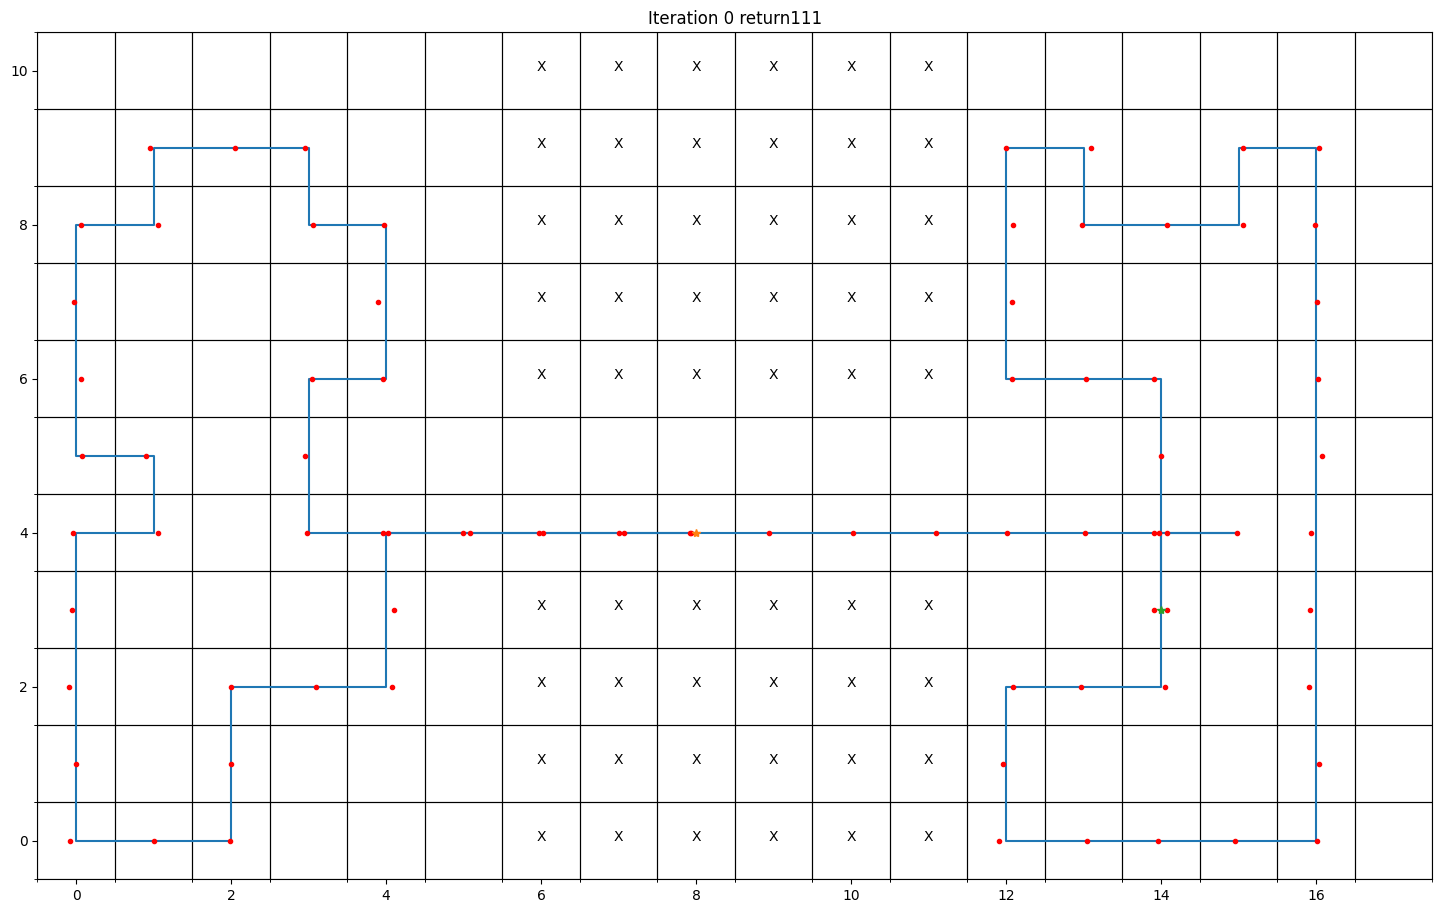

In [22]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
params["common"]["batch_size"]=1
mat_state = []
mat_return = []
env.initialize(params["env"]["initial"])
mat_state.append(env.state)
init_state = env.state
for h_iter in range(H-1):
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        batch_state = mat_state[-1].reshape(-1, 1).float()
        # append time index to the state
        batch_state = torch.cat(
            [batch_state, h_iter*torch.ones_like(batch_state)], 1)
    else:
        batch_state = append_state(mat_state, H-1)
    probs = bc_agent.policy(batch_state.to(device))
    actions_dist = torch.distributions.Categorical(probs)
    actions = actions_dist.sample()
    env.step(h_iter, actions.cpu())
    mat_state.append(env.state)  # s+1
path = create_path_with_timesteps(mat_state)
print(path)
print(env.weighted_traj_return(mat_state, type = params["alg"]["type"]))
visu = Visu(env_params=params["env"])
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

从 100 条轨迹中找到的最佳回报是: 137
最佳轨迹路径:
[(0, 80), (1, 79), (2, 78), (3, 77), (4, 76), (5, 58), (6, 40), (7, 39), (8, 38), (9, 20), (10, 2), (11, 1), (12, 0), (13, 18), (14, 36), (15, 54), (16, 72), (17, 73), (18, 91), (19, 90), (20, 108), (21, 126), (22, 144), (23, 145), (24, 163), (25, 164), (26, 165), (27, 147), (28, 148), (29, 130), (30, 112), (31, 111), (32, 93), (33, 75), (34, 76), (35, 77), (36, 78), (37, 79), (38, 80), (39, 81), (40, 82), (41, 83), (42, 84), (43, 85), (44, 86), (45, 68), (46, 50), (47, 49), (48, 48), (49, 30), (50, 12), (51, 13), (52, 14), (53, 15), (54, 16), (55, 34), (56, 52), (57, 70), (58, 88), (59, 106), (60, 124), (61, 142), (62, 160), (63, 178), (64, 177), (65, 159), (66, 158), (67, 157), (68, 175), (69, 174), (70, 156), (71, 138), (72, 120), (73, 121), (74, 122), (75, 123), (76, 122), (77, 104), (78, 122), (79, 104)]
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 

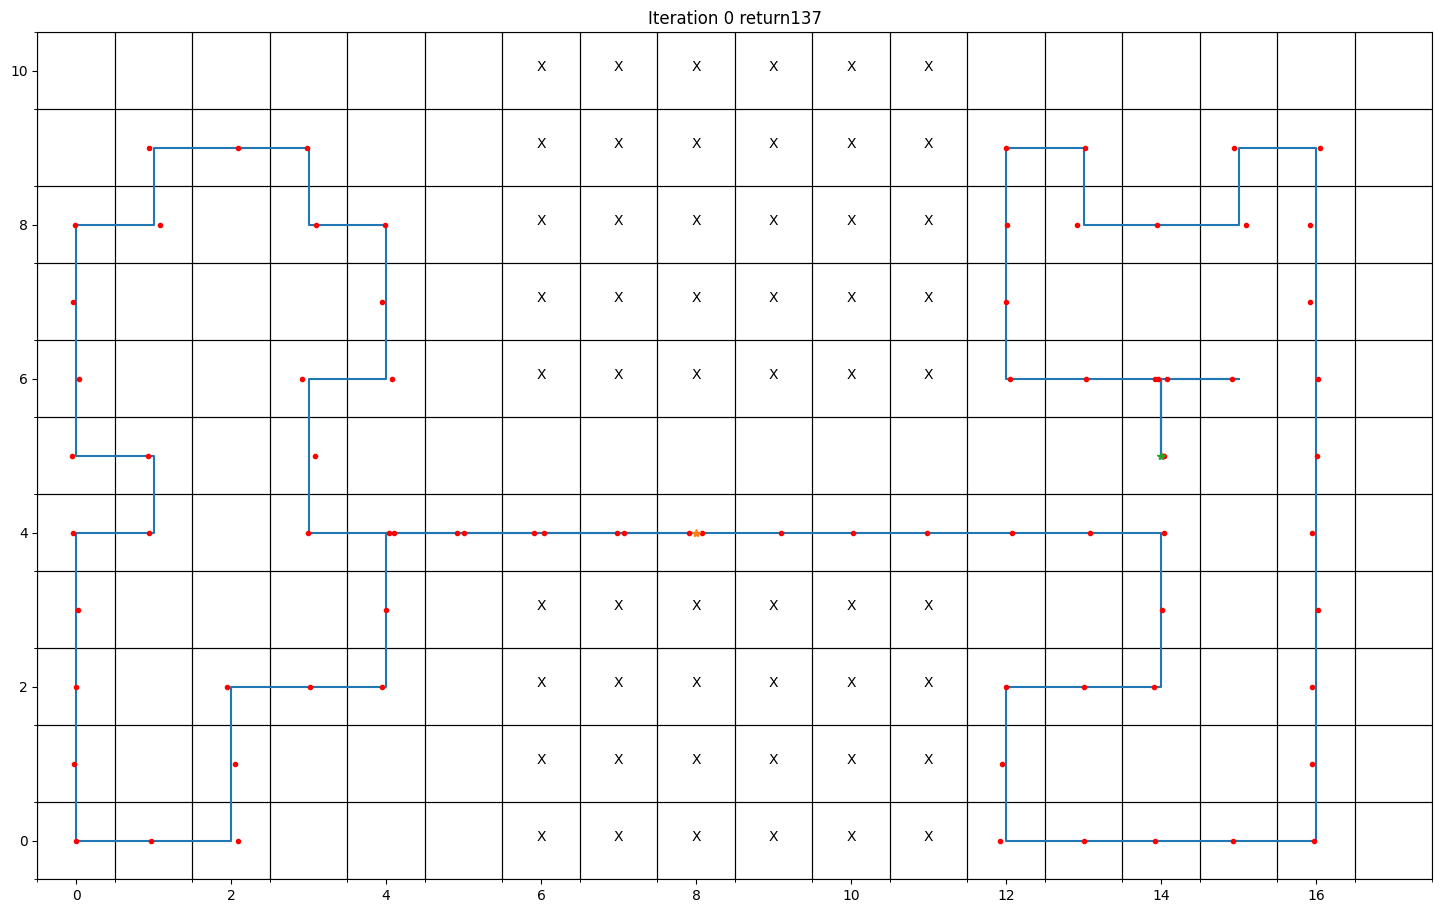

In [26]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu

# 1. 设置生成100条轨迹
num_trajectories = 100
params["common"]["batch_size"] = num_trajectories

# 2. 运行环境以生成所有轨迹
mat_state = []
env.initialize(params["env"]["initial"])
mat_state.append(env.state)

for h_iter in range(H - 1):
    batch_state = append_state(mat_state, H - 1)
    probs = bc_agent.policy(batch_state.to(device))
    actions_dist = torch.distributions.Categorical(probs)
    actions = actions_dist.sample()
    env.step(h_iter, actions.cpu())
    mat_state.append(env.state)  # s+1

# 3. 计算所有轨迹的回报并找到最佳轨迹
all_returns = env.weighted_traj_return(mat_state, type=params["alg"]["type"])
best_traj_index = torch.argmax(all_returns)
max_return = all_returns[best_traj_index]

print(f"从 {num_trajectories} 条轨迹中找到的最佳回报是: {max_return.item()}")

# 4. 提取最佳轨迹的状态
best_trajectory_states = [state_tensor[best_traj_index] for state_tensor in mat_state]

# 5. 创建路径并进行可视化
path = create_path_with_timesteps(best_trajectory_states)
print("最佳轨迹路径:")
print(path)

visu = Visu(env_params=params["env"])
visu.path_return(max_return.item())
visu.visu_path(path, env.Hori_ActionTransitionMatrix)